# Blind DPS implementation

Work in progress

## Imports

In [2]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils import load_image
from tqdm import tqdm  # to visualize progress

device = "cuda"

url = get_image_url("butterfly.png")

# x_true = load_url_image(url=url, img_size=64).to(device)
x_true = load_image("00000.png", img_size=256).to(device)
x_true = x_true[:, 0:3, :, :]
x = x_true.clone()

## Setting the forward operator

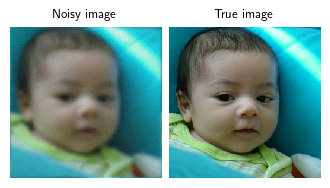

In [4]:
sigma = 0.1  # noise level

blur_std = 3.0
noise_std = 0.02

k_true = dinv.physics.blur.gaussian_blur(sigma=blur_std, angle=0.0).to(device)
k_true = torch.nn.functional.pad(k_true, (21, 20, 21, 20))

physics_true = dinv.physics.Blur(filter=k_true,
                            padding="circular",
                            noise_model=dinv.physics.GaussianNoise(sigma=noise_std),
                            device=device)

y = physics_true(x_true)

imgs = [y, x_true]
plot(imgs, ["Noisy image", "True image"], cmap="gray")

## Image diffusion model and parameters

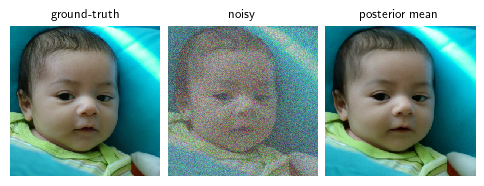

In [6]:
model = dinv.models.DiffUNet().to(device)

num_train_timesteps = 1000  # Number of timesteps used during training

def get_betas(
    beta_start=0.1 / 1000, beta_end=20 / 1000, num_train_timesteps=num_train_timesteps
):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)

    return betas

# Utility function to let us easily retrieve \bar\alpha_t
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a

betas = get_betas()

t = torch.ones(1, device=device) * 50  # choose some arbitrary timestep
at = compute_alpha(betas, t.long())
sigmat = (1 - at).sqrt() / at.sqrt()

x0 = x_true
xt = x0 + sigmat * torch.randn_like(x0)

# apply denoiser
x0_t = model(xt, sigmat)

# Visualize
imgs = [x0, xt, x0_t]
plot(
    imgs,
    titles=["ground-truth", "noisy", "posterior mean"],
)

## DPS step on the image

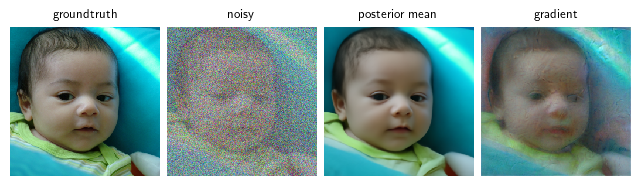

In [7]:
x0 = x_true * 2.0 - 1.0  # [0, 1] -> [-1, 1]

data_fidelity = L2()

# xt ~ q(xt|x0)
i = 200  # choose some arbitrary timestep
t = (torch.ones(1) * i).to(device)
at = compute_alpha(betas, t.long())
xt = at.sqrt() * x0 + (1 - at).sqrt() * torch.randn_like(x0)

# DPS
with torch.enable_grad():
    # Turn on gradient
    xt.requires_grad_()

    # normalize to [0,1], denoise, and rescale to [-1, 1]
    x0_t = model(xt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1
    # Log-likelihood
    ll = data_fidelity(x0_t, y, physics_true).sqrt().sum()
    # Take gradient w.r.t. xt
    grad_ll = torch.autograd.grad(outputs=ll, inputs=xt)[0]

# Visualize
imgs = [x0, xt, x0_t, grad_ll]
plot(
    imgs,
    titles=["groundtruth", "noisy", "posterior mean", "gradient"],
)

## Kernel diffusion model

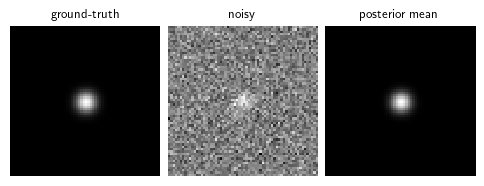

In [8]:
model_k = dinv.models.DiffUNet(in_channels=1, out_channels=1).to(device)

k0 = k_true / (k_true.max() - k_true.min()) # sum = 1 -> [0, 1]
k0 = k0 * 2.0 - 1.0 # [0, 1] -> [-1, 1]
i = 200  # choose some arbitrary timestep
t = (torch.ones(1) * i).to(device)
at = compute_alpha(betas, t.long())
sigmat = (1 - at).sqrt() / at.sqrt()

kt = at.sqrt() * k0 + (1 - at).sqrt() * torch.randn_like(k0)

k0_t = model_k(kt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1

# Visualize
imgs = [k0, kt, k0_t]
plot(
    imgs,
    titles=["ground-truth", "noisy", "posterior mean"],
)

## DPS step on the kernel

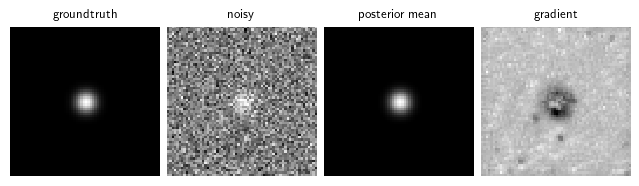

In [20]:
from deepinv.physics.functional.convolution import conv2d
from torch import nn

model_k = dinv.models.DiffUNet(in_channels=1, out_channels=1).to(device)

data_fidelity = L2()
k0 = k_true / (k_true.max() - k_true.min()) # sum = 1 -> [0, 1]
k0 = k0 * 2.0 - 1.0 # [0, 1] -> [-1, 1]
x0 = x_true * 2.0 - 1.0  # [0, 1] -> [-1, 1]

i = 200  # choose some arbitrary timestep
t = (torch.ones(1) * i).to(device)
at = compute_alpha(betas, t.long())
kt = at.sqrt() * k0 + (1 - at).sqrt() * torch.randn_like(k0)

physics = dinv.physics.Blur(filter=torch.ones_like(kt),
                            padding="circular",
                            noise_model=dinv.physics.GaussianNoise(sigma=noise_std),
                            device=device)

regularization_k = dinv.optim.L1Prior()

with torch.enable_grad():
    # Turn on gradient
    kt.requires_grad_()
    
    # normalize to [0,1], denoise, and rescale to [-1, 1]
    k0_t = model_k(kt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1
    
    # physics.filter = torch.nn.Parameter(k0_t, requires_grad=True)
    k0_t = (k0_t + 1.0) / 2.0
    k0_t /= k0_t.sum()
    y0_t = conv2d(x0, k0_t, padding="circular")
    
    ll_k = data_fidelity.d(y0_t, y).sqrt().sum() + regularization_k(k0)
    # ll_k = torch.linalg.norm(y0_t - y) + regularization_k(k0)
    
# Take gradient w.r.t. xt
grad_ll = torch.autograd.grad(outputs=ll_k, inputs=kt)[0]

imgs = [k0, kt, k0_t, grad_ll]
    
plot(imgs, titles=["groundtruth", "noisy", "posterior mean", "gradient"],)

## DPS step on the kernel and the image

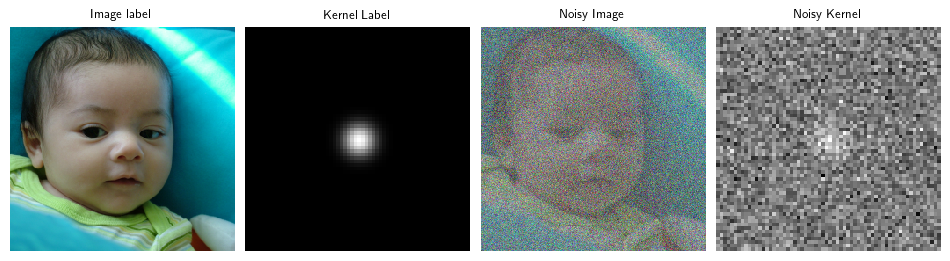

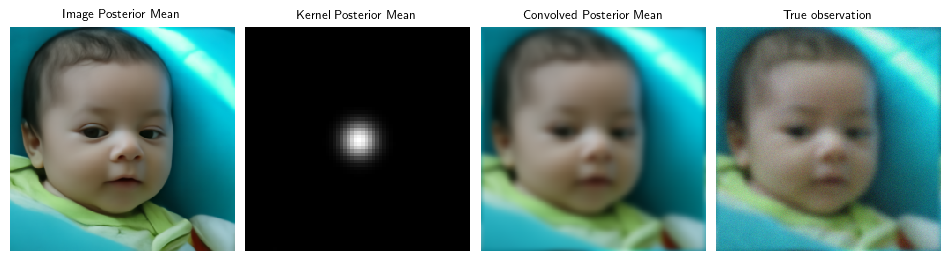

In [25]:
from deepinv.physics.functional.convolution import conv2d
from torch import nn

model_k = dinv.models.DiffUNet(in_channels=1, out_channels=1).to(device)

data_fidelity = L2()
k0 = k_true / (k_true.max() - k_true.min()) # sum = 1 -> [0, 1]
k0 = k0 * 2.0 - 1.0 # [0, 1] -> [-1, 1]
x0 = x_true * 2.0 - 1.0  # [0, 1] -> [-1, 1]

i = 200  # choose some arbitrary timestep
t = (torch.ones(1) * i).to(device)
at = compute_alpha(betas, t.long())
kt = at.sqrt() * k0 + (1 - at).sqrt() * torch.randn_like(k0)
xt = at.sqrt() * x0 + (1 - at).sqrt() * torch.randn_like(x0)

physics = dinv.physics.Blur(filter=torch.ones_like(kt),
                            padding="circular",
                            noise_model=dinv.physics.GaussianNoise(sigma=noise_std),
                            device=device)

regularization_k = dinv.optim.L1Prior()

with torch.enable_grad():
    # Turn on gradient
    kt.requires_grad_()
    xt.requires_grad_()
    
    # normalize to [0,1], denoise, and rescale to [-1, 1]
    k0_t = model_k(kt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1
    x0_t = model(xt / 2 + 0.5, (1 - at).sqrt() / at.sqrt() / 2) * 2 - 1
    
    # physics.filter = torch.nn.Parameter(k0_t, requires_grad=True)
    k0_t = (k0_t + 1.0) / 2.0
    k0_t /= k0_t.sum()
    y0_t = conv2d(x0_t, k0_t, padding="circular")
    
    # Log-likelihood
    # ll_x = data_fidelity.d(y0_t, y).sqrt().sum()
    # ll_k = data_fidelity.d(y0_t, y).sqrt().sum() #+ regularization_k(k0)
    ll_x = torch.linalg.norm(y0_t - y)
    ll_k = torch.linalg.norm(y0_t - y) + regularization_k(k0)
    
# Take gradient w.r.t. xt
grad_ll = torch.autograd.grad(outputs=ll_k, inputs=kt, retain_graph=True)[0]
grad_ll_x = torch.autograd.grad(outputs=ll_x, inputs=xt)[0]

plot([x0, k0, xt, kt], 
     titles=["Image label", "Kernel Label", "Noisy Image", "Noisy Kernel"],
     figsize=(12, 3))
plot([x0_t, k0_t, y0_t, y], 
     titles=["Image Posterior Mean", "Kernel Posterior Mean", "Convolved Posterior Mean", "True observation"], 
     figsize=(12, 3))

## Blind DPS algorithm

The notebook can be run starting from this cell to avoid all the previous tests

In [26]:
from deepinv.physics.functional.convolution import conv2d
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils import load_image
from tqdm import tqdm  # to visualize progress

device = "cuda"

# url = get_image_url("butterfly.png")

# x_true = load_url_image(url=url, img_size=64).to(device)
x_true = load_image("00000.png", img_size=256).to(device)
x_true = x_true[:, 0:3, :, :]
x = x_true.clone()

num_train_timesteps = 1000  # Number of timesteps used during training


def get_betas(
    beta_start=0.1 / 1000, beta_end=20 / 1000, num_train_timesteps=num_train_timesteps
):
    betas = np.linspace(beta_start, beta_end, num_train_timesteps, dtype=np.float32)
    betas = torch.from_numpy(betas).to(device)

    return betas


# Utility function to let us easily retrieve \bar\alpha_t
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


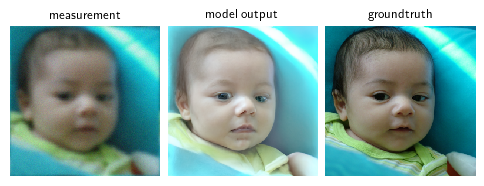

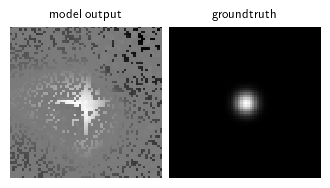

In [35]:
betas = get_betas()

num_steps = 1000
skip = num_train_timesteps // num_steps

batch_size = 1
eta = 1.0

# seq = range(0, num_train_timesteps, skip)
seq = range(0, num_steps, 1)
seq_next = [-1] + list(seq[:-1])
time_pairs = list(zip(reversed(seq), reversed(seq_next)))

# Physics

n_channels = 3  # 3 for color images, 1 for gray-scale images
blur_std = 3.0
noise_std = 0.02

k_true = dinv.physics.blur.gaussian_blur(sigma=blur_std, angle=0.0).to(device)
k_true = torch.nn.functional.pad(k_true, (21, 20, 21, 20))

physics_true = dinv.physics.Blur(filter=k_true,
                            padding="circular",
                            noise_model=dinv.physics.GaussianNoise(sigma=noise_std),
                            device=device)

y = physics_true(x_true.to(device))

# Losses 

data_fidelity = L2()
regularization_k = dinv.optim.L1Prior()

# models 

model_x = dinv.models.DiffUNet(in_channels=3, out_channels=3).to(device)
model_k = dinv.models.DiffUNet(in_channels=1, out_channels=1).to(device)

# initial sample from x_T

x = torch.randn_like(x0)
k = torch.randn_like(k_true)

# Tried different initializations to see if it helps

# k = k_true
# x = x_true

# k0 = k_true / (k_true.max() - k_true.min()) # sum = 1 -> [0, 1]
# k0 = k0 * 2.0 - 1.0 # [0, 1] -> [-1, 1]
# x0 = x_true * 2.0 - 1.0  # [0, 1] -> [-1, 1]
# t = (torch.ones(1) * num_steps).to(device)
# at = compute_alpha(betas, t.long())
# k = at.sqrt() * k0 + (1 - at).sqrt() * torch.randn_like(k0)
# x = at.sqrt() * x0 + (1 - at).sqrt() * torch.randn_like(x0)

physics = dinv.physics.Blur(filter=torch.ones_like(k),
                            padding="circular",
                            device=device)
xs = [x]
ks = [k]
x0_preds = []
k0_preds = []

# Parameters reported in the paper
reg_factor = 1.0
grad_factor = 0.3

for i, j in tqdm(time_pairs):
    t = (torch.ones(batch_size) * i).to(device)
    next_t = (torch.ones(batch_size) * j).to(device)

    at = compute_alpha(betas, t.long())
    at_next = compute_alpha(betas, next_t.long())

    xt = xs[-1].to(device)
    kt = ks[-1].to(device)
    
    with torch.enable_grad():
        xt.requires_grad_()
        kt.requires_grad_()
        
        # 1. denoising step
        # we call the denoiser using standard deviation instead of the time step.
        
        # Image
        aux_x = xt / 2 + 0.5
        x0_t = 2 * model_x(aux_x, (1 - at).sqrt() / at.sqrt() / 2) - 1
        x0_t = torch.clip(x0_t, -1.0, 1.0)  # optional
        
        # Kernel
        aux_k = kt / 2 + 0.5
        k0_t = 2 * model_k(kt, (1 - at).sqrt() / at.sqrt() / 2) - 1
        # k0_t = torch.clip(k0_t, -1.0, 1.0) # optional
        k0_t = (k0_t + 1.0) / 2.0
        k0_t /= k0_t.sum()
        
        physics.filter = torch.nn.Parameter(k0_t, requires_grad=True)
        
        # It would be better to use the "physics" here to compute the likelihood
        # but it seems that it detaches kt from the computational graph
        y0_t = conv2d(x0_t, k0_t, padding="constant")

        # 2. likelihood gradient approximation
        # ll_x = data_fidelity.d(y0_t, y).sum()
        ll_x = torch.linalg.norm(y0_t - y)
        # ll_k = data_fidelity.d(y0_t, y).sum() #+ reg_factor * regularization_k(k0_t) # + torch.linalg.norm(k0_t.view(-1), ord=1) 
        ll_k = torch.linalg.norm(y0_t - y) + regularization_k(k0)
        
    norm_grad_x = torch.autograd.grad(outputs=ll_x, inputs=xt, retain_graph=True)[0]
    norm_grad_x = norm_grad_x.detach()

    norm_grad_k = torch.autograd.grad(outputs=ll_k, inputs=kt)[0]
    norm_grad_k = norm_grad_k.detach()
    
    sigma_tilde = ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() * eta
    c2 = ((1 - at_next) - sigma_tilde**2).sqrt()

    # 3. noise step
    epsilon_x = torch.randn_like(xt)
    espilon_k = torch.randn_like(kt)
    
    # Trick in the Blind-DPS implementation, not reported in the paper
    # grad_factor = at

    # 4. DDPM(IM) step
    xt_next = (
        (at_next.sqrt() - c2 * at.sqrt() / (1 - at).sqrt()) * x0_t
        + sigma_tilde * epsilon_x
        + c2 * xt / (1 - at).sqrt()
        - grad_factor * norm_grad_x
    )

    kt_next = (
        (at_next.sqrt() - c2 * at.sqrt() / (1 - at).sqrt()) * k0_t
        + sigma_tilde * espilon_k
        + c2 * kt / (1 - at).sqrt()
        - grad_factor * norm_grad_k
    )
    
    # if(i % 100 == 0):
        # plot(norm_grad_k)        
        
    x0_preds.append(x0_t.detach().to("cpu"))
    k0_preds.append(k0_t.detach().to("cpu"))
    xs.append(xt_next.detach().to("cpu"))
    ks.append(kt_next.detach().to("cpu"))

    del ll_x, ll_k
    torch.cuda.empty_cache()    
    
recon = xs[-1]

# plot the results
x = recon / 2 + 0.5
imgs = [y, x, x_true]
k = ks[-1] / 2 + 0.5
k = k / k.sum()
kernels = [k, k_true]
plot(imgs, titles=["measurement", "model output", "groundtruth"])
plot(kernels, titles=["model output", "groundtruth"])
